# PROBLEM STATEMENT: INFRASTRUCTURE SAFETY OPTIMIZATION THROUGH PATTERN ANALYSIS

##### **Challenge:** Urban planners struggle to identify which road infrastructure improvements (such as junction redesign, speed limit changes, or lighting) would have the highest impact on reducing accidents and casualties. 

##### **Solution:** Reveal severity patterns and rank high-risk locations to guide targeted infrastructure improvements.

##### **AUTHOR:** SRISHTI LAMBA,NIKITA SHARMA 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\srrml\Desktop\project\ML\Zeta-x-\dft-road-casualty-statistics-collision-2024.csv")
df.head()

,collision_index,collision_year,collision_ref_no,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,collision_severity,number_of_vehicles,...,carriageway_hazards_historic,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,enhanced_severity_collision,collision_injury_based,collision_adjusted_severity_serious,collision_adjusted_severity_slight
0,202417H103224,2024,17H103224,448894,532505,-1.24312,54.68523,17,3,2,...,-1,0,1,2,2,E01011983,3,1,0.000000,1.000000
1,202417M217924,2024,17M217924,452135,519436,-1.19517,54.56747,17,2,2,...,-1,0,1,3,2,E01012061,7,1,1.000000,0.000000
2,202417S204524,2024,17S204524,445427,522924,-1.29837,54.59946,17,3,2,...,0,0,2,1,2,E01012280,-1,0,0.111621,0.888379
3,2.02448E+12,2024,481510889,533587,181174,-0.07626,51.51371,48,2,1,...,-1,0,1,1,2,E01000005,7,1,1.000000,0.000000
4,2.02448E+12,2024,481563500,532676,180902,-0.08948,51.51148,48,2,1,...,-1,0,1,1,2,E01032739,5,1,1.000000,0.000000


### FEATURE ENGINEERING

In [3]:
df["is_serious_or_fatal"] = df["collision_severity"].isin([1, 2]).astype(int)
y = df["is_serious_or_fatal"]

df["is_urban"] = (df["speed_limit"] <= 40).astype(int)
df["is_high_speed"] = (df["speed_limit"] >= 50).astype(int)
df["has_crossing"] = ((df["pedestrian_crossing_human_control_historic"] > 0) |
                      (df["pedestrian_crossing_physical_facilities_historic"] > 0) |
                      (df["pedestrian_crossing"] > 0)).astype(int)
df["has_traffic_control"] = (df["junction_control"] != "None").astype(int)

features = ["speed_limit","is_urban","is_high_speed",
            "has_crossing","has_traffic_control","number_of_vehicles"]

junction_cols = [c for c in df.columns if c.startswith("junction_detail_")]
road_cols = [c for c in df.columns if c.startswith("road_type_")]

X = df[features + junction_cols + road_cols]


### TRAIN/TEST SPLIT

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### MODEL TRAINING

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=300, class_weight="balanced"),
}

for m in models:
    models[m].fit(X_train, y_train)

In [6]:
model_results = {}

for name, model in models.items():

    probs = model.predict_proba(X_test)[:, 1]
    precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, probs)
    fpr, tpr, thresholds_roc = roc_curve(y_test, probs)
    pr_auc = auc(recall_curve, precision_curve)
    roc_auc = auc(fpr, tpr)
    
    J_scores = tpr - fpr
    best_idx = np.argmax(J_scores)
    best_threshold = thresholds_roc[best_idx]

    y_pred_opt = (probs >= best_threshold).astype(int)

    model_results[name] = {
        "recall": recall_score(y_test, y_pred_opt),
        "precision": precision_score(y_test, y_pred_opt),
        "f1": f1_score(y_test, y_pred_opt),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_opt),
        "pr_auc": pr_auc,
        "roc_auc": roc_auc,
        "best_threshold": best_threshold,
        "conf_matrix": confusion_matrix(y_test, y_pred_opt),
        "precision_curve": precision_curve,
        "recall_curve": recall_curve,
        "fpr": fpr,
        "tpr": tpr
    }

    print(f"MODEL: {name}")
    print(f"Best Threshold (Youden): {best_threshold:.3f}")
    print(classification_report(y_test, y_pred_opt))

MODEL: LogisticRegression
Best Threshold (Youden): 0.492
              precision    recall  f1-score   support

           0       0.80      0.59      0.68     15172
           1       0.31      0.57      0.40      5014

    accuracy                           0.58     20186
   macro avg       0.56      0.58      0.54     20186
weighted avg       0.68      0.58      0.61     20186

MODEL: RandomForest
Best Threshold (Youden): 0.467
              precision    recall  f1-score   support

           0       0.81      0.54      0.65     15172
           1       0.31      0.62      0.41      5014

    accuracy                           0.56     20186
   macro avg       0.56      0.58      0.53     20186
weighted avg       0.69      0.56      0.59     20186



### MODEL COMPARISON

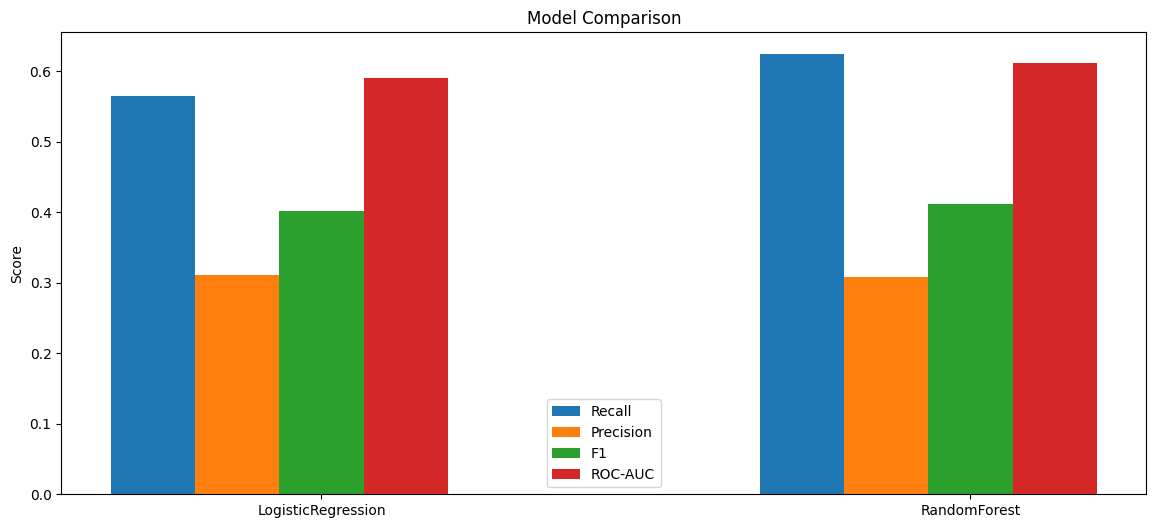

In [7]:
labels = ["Recall", "Precision", "F1", "ROC-AUC"]
keys = ["recall", "precision", "f1", "roc_auc"]

x = np.arange(len(model_results))
width = 0.13

plt.figure(figsize=(14, 6))
for i, key in enumerate(keys):
    values = [model_results[m][key] for m in model_results]
    plt.bar(x + i * width, values, width, label=labels[i])

plt.xticks(x + width * 2, model_results.keys())
plt.title("Model Comparison")
plt.ylabel("Score")
plt.legend()
plt.show()

### CONFUSION MATRIX

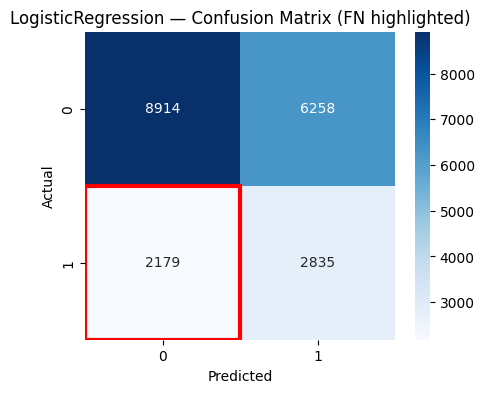

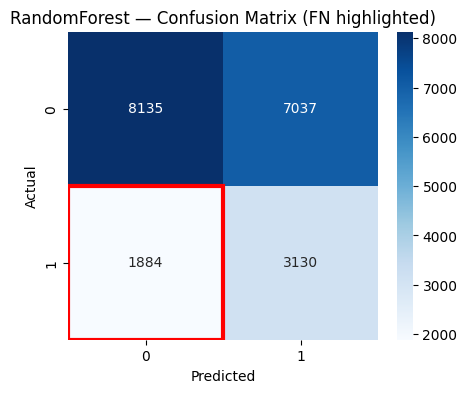

In [8]:
for name, r in model_results.items():
    cm = r["conf_matrix"]

    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    ax.add_patch(plt.Rectangle((0, 1), 1, 1, fill=False, edgecolor='red', lw=3))
    plt.title(f"{name} — Confusion Matrix (FN highlighted)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

### ROC CURVE

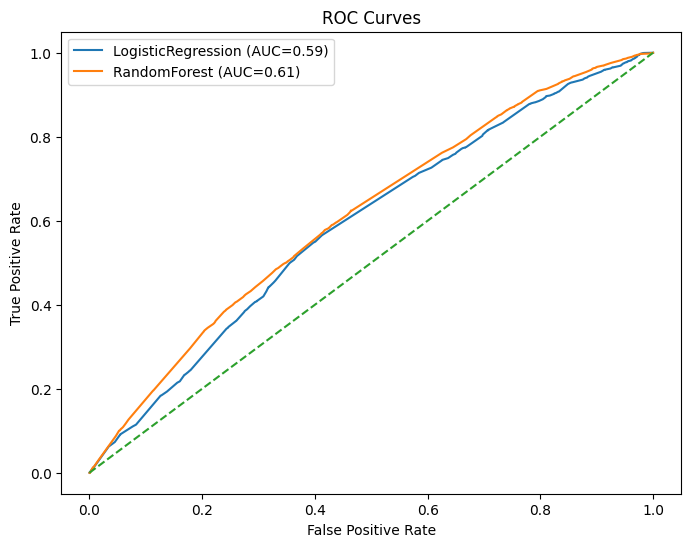

In [9]:
plt.figure(figsize=(8, 6))
for name, r in model_results.items():
    plt.plot(r["fpr"], r["tpr"], label=f"{name} (AUC={r['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], "--")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### RRECISION-RECALL CURVE

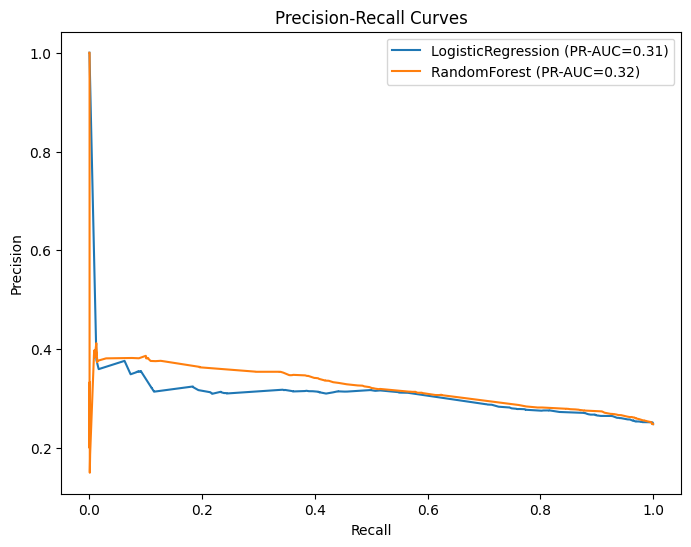

In [10]:
plt.figure(figsize=(8, 6))
for name, r in model_results.items():
    plt.plot(r["recall_curve"], r["precision_curve"],
             label=f"{name} (PR-AUC={r['pr_auc']:.2f})")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()